In [1]:
## AE Depth Comparison Experiment Notebook
# 1. Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/projects/ae-vae-anomaly-detection/data/processed/cleaned.csv'

Mounted at /content/drive


In [2]:
# 2. Load Processed Data
import pandas as pd

#load cleaned data
cleaned_df = pd.read_csv(data_path)
print(f'Loaded cleaned data: {cleaned_df.shape[0]} rows, {cleaned_df.shape[1]} columns')

# get a small sample for training model
df = cleaned_df.sample(frac=1, random_state=42)
print(f'Sampled data: {df.shape[0]} rows, {df.shape[1]} columns')

Loaded cleaned data: 640788 rows, 178 columns
Sampled data: 640788 rows, 178 columns


In [3]:
# 3. Train/Test Split
from sklearn.model_selection import train_test_split

# Separate features and label
X = df.drop(columns='label')
y = df['label']

# First split off a mixed test set (normal+anomaly), stratified to keep the same
#    anomaly ratio in train and test.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# From the remaining (X_temp / y_temp) we only train on the normal samples:
#    i.e. drop the anomalies from this “train+val pool”
X_train_val = X_temp[y_temp == 0]

# Finally split that normal‐only pool into X_train / X_val
X_train, X_val = train_test_split(
    X_train_val,
    test_size=0.2,
    random_state=42
)

# Now:
#  - X_train, X_val are both *only* normal samples (for AE/VAE training & early stopping)
#  - X_test / y_test is your held‐out mixed set (with both normal and anomalous),
#    and it never overlaps with X_train or X_val

In [5]:
!mkdir -p /content/src/models

In [6]:
import sys
sys.path.append('/content/src')
from models.ae_model import build_ae, build_ae_deep, train_autoencoder, plot_training_history
from models.ae_evaluation import evaluate_anomaly_detection, visualize_reconstruction, compute_reconstruction_error

In [9]:
# 4. Shallow AE
ae_shallow = build_ae(input_dim=X_train.shape[1], encoding_dim=16)
hist_shallow, model_shallow = train_autoencoder(ae_shallow, X_train, X_val,
                                                 save_path='best_ae_shallow.h5')

Epoch 1/100
6256/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0335 - mae: 0.0675

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0334 - mae: 0.0675 - val_loss: 9.0775e-04 - val_mae: 0.0066 - learning_rate: 0.0010
Epoch 2/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0101

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 0.0015 - mae: 0.0101 - val_loss: 5.1618e-04 - val_mae: 0.0053 - learning_rate: 0.0010
Epoch 3/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0091

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0012 - mae: 0.0091 - val_loss: 4.4387e-04 - val_mae: 0.0047 - learning_rate: 0.0010
Epoch 4/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0088

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0011 - mae: 0.0088 - val_loss: 3.9980e-04 - val_mae: 0.0045 - learning_rate: 0.0010
Epoch 5/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0011 - mae: 0.0087 - val_loss: 4.3465e-04 - val_mae: 0.0044 - learning_rate: 0.0010
Epoch 6/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mae: 0.0086

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.0010 - mae: 0.0086 - val_loss: 3.8250e-04 - val_mae: 0.0046 - learning_rate: 0.0010
Epoch 7/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - mae: 0.0085


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0010 - mae: 0.0085 - val_loss: 3.3783e-04 - val_mae: 0.0042 - learning_rate: 0.0010
Epoch 8/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9723e-04 - mae: 0.0084

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 9.9723e-04 - mae: 0.0084 - val_loss: 3.2440e-04 - val_mae: 0.0039 - learning_rate: 5.0000e-04
Epoch 9/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 9.8799e-04 - mae: 0.0083 - val_loss: 3.4863e-04 - val_mae: 0.0042 - learning_rate: 5.0000e-04
Epoch 10/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9331e-04 - mae: 0.0083
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 9.9331e-04 - mae: 0.0083 - val_loss: 3.2951e-04 - val_mae: 0.0040 - learning_rate: 5.0000e-04
Epoch 11/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8195e-04 - mae: 0.0083

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 9.8195e-04 - mae: 0.0083 - val_loss: 3.1488e-04 - val_mae: 0.0037 - learning_rate: 2.5000e-04
Epoch 12/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 9.8399e-04 - mae: 0.0083 - val_loss: 3.2116e-04 - val_mae: 0.0039 - learning_rate: 2.5000e-04
Epoch 13/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7779e-04 - mae: 0.0082
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 9.7778e-04 - mae: 0.0082 - val_loss: 3.3038e-04 - val_mae: 0.0040 - learning_rate: 2.5000e-04
Epoch 14/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 9.6882e-04 - mae: 0.0082 - val_loss: 3.1784e-04 - val_mae: 0.0038 - learning_rate: 1.2500e-04
Epoch 15/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 9.6542e-04 - mae: 0.0082 - val_loss: 3.1839e-04 - val_mae: 0.0038 - learning_rate: 1.2500e-04
Epoch 16/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9


Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 9.7080e-04 - mae: 0.0082 - val_loss: 3.0767e-04 - val_mae: 0.0037 - learning_rate: 1.2500e-04
Epoch 17/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7399e-04 - mae: 0.0082

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 9.7399e-04 - mae: 0.0082 - val_loss: 3.0729e-04 - val_mae: 0.0037 - learning_rate: 6.2500e-05
Epoch 18/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 9.7282e-04 - mae: 0.0082 - val_loss: 3.2076e-04 - val_mae: 0.0038 - learning_rate: 6.2500e-05
Epoch 19/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6832e-04 - mae: 0.0082
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 9.6832e-04 - mae: 0.0082 - val_loss: 3.0974e-04 - val_mae: 0.0038 - learning_rate: 6.2500e-05
Epoch 20/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6859e-04 - mae: 0.0082

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 9.6859e-04 - mae: 0.0082 - val_loss: 3.0670e-04 - val_mae: 0.0037 - learning_rate: 3.1250e-05
Epoch 21/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 9.6704e-04 - mae: 0.0082 - val_loss: 3.1724e-04 - val_mae: 0.0037 - learning_rate: 3.1250e-05
Epoch 22/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6095e-04 - mae: 0.0082
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 9.6095e-04 - mae: 0.0082 - val_loss: 3.1961e-04 - val_mae: 0.0038 - learning_rate: 3.1250e-05
Epoch 23/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 9.5670e-04 - mae: 0.0082 - val_loss: 3.1004e-04 - val_mae: 0.0038 - learning_rate: 1.5625e-05
Epoch 24/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 9.6385e-04 - mae: 0.0082 - val_loss: 3.1158e-04 - val_mae: 0.0038 - learning_rate: 1.5625e-05
Epoch 25/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

In [7]:
# 5. Deep AE
ae_deep = build_ae_deep(input_dim=X_train.shape[1], encoding_dim=16)
hist_deep, model_deep = train_autoencoder(ae_deep, X_train, X_val,
                                           save_path='best_ae_deep.h5')

Epoch 1/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0515 - mae: 0.0850

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 57s 8ms/step - loss: 0.0514 - mae: 0.0850 - val_loss: 0.0014 - val_mae: 0.0084 - learning_rate: 0.0010
Epoch 2/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mae: 0.0107

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - loss: 0.0018 - mae: 0.0107 - val_loss: 8.2060e-04 - val_mae: 0.0065 - learning_rate: 0.0010
Epoch 3/100
6260/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mae: 0.0090

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 0.0012 - mae: 0.0090 - val_loss: 5.0163e-04 - val_mae: 0.0052 - learning_rate: 0.0010
Epoch 4/100
6261/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8053e-04 - mae: 0.0081

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 9.8050e-04 - mae: 0.0081 - val_loss: 4.7658e-04 - val_mae: 0.0051 - learning_rate: 0.0010
Epoch 5/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1178e-04 - mae: 0.0079

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 9.1176e-04 - mae: 0.0079 - val_loss: 4.1853e-04 - val_mae: 0.0045 - learning_rate: 0.0010
Epoch 6/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5467e-04 - mae: 0.0077

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 8.5466e-04 - mae: 0.0077 - val_loss: 3.6463e-04 - val_mae: 0.0043 - learning_rate: 0.0010
Epoch 7/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 8.2376e-04 - mae: 0.0076 - val_loss: 3.6925e-04 - val_mae: 0.0044 - learning_rate: 0.0010
Epoch 8/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0159e-04 - mae: 0.0075

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 8.0158e-04 - mae: 0.0075 - val_loss: 3.3974e-04 - val_mae: 0.0042 - learning_rate: 0.0010
Epoch 9/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9126e-04 - mae: 0.0075


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 7.9126e-04 - mae: 0.0075 - val_loss: 3.3082e-04 - val_mae: 0.0040 - learning_rate: 0.0010
Epoch 10/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6590e-04 - mae: 0.0074

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 7.6590e-04 - mae: 0.0074 - val_loss: 3.2500e-04 - val_mae: 0.0037 - learning_rate: 5.0000e-04
Epoch 11/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5709e-04 - mae: 0.0073

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 7.5709e-04 - mae: 0.0073 - val_loss: 3.0882e-04 - val_mae: 0.0038 - learning_rate: 5.0000e-04
Epoch 12/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5540e-04 - mae: 0.0073


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 7.5540e-04 - mae: 0.0073 - val_loss: 3.0071e-04 - val_mae: 0.0037 - learning_rate: 5.0000e-04
Epoch 13/100
6262/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4741e-04 - mae: 0.0072

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 7.4740e-04 - mae: 0.0072 - val_loss: 2.9157e-04 - val_mae: 0.0038 - learning_rate: 2.5000e-04
Epoch 14/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3468e-04 - mae: 0.0072

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 7.3469e-04 - mae: 0.0072 - val_loss: 2.8452e-04 - val_mae: 0.0036 - learning_rate: 2.5000e-04
Epoch 15/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3836e-04 - mae: 0.0072
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 7.3836e-04 - mae: 0.0072 - val_loss: 2.9487e-04 - val_mae: 0.0037 - learning_rate: 2.5000e-04
Epoch 16/100
6259/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3067e-04 - mae: 0.0072

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 7.3067e-04 - mae: 0.0072 - val_loss: 2.7371e-04 - val_mae: 0.0034 - learning_rate: 1.2500e-04
Epoch 17/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 7.2953e-04 - mae: 0.0072 - val_loss: 2.9780e-04 - val_mae: 0.0036 - learning_rate: 1.2500e-04
Epoch 18/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2611e-04 - mae: 0.0072
Epoch 18: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 7.2611e-04 - mae: 0.0072 - val_loss: 2.7802e-04 - val_mae: 0.0036 - learning_rate: 1.2500e-04
Epoch 19/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 7.2640e-04 - mae: 0.0072 - val_loss: 2.7696e-04 - val_mae: 0.0035 - learning_rate: 6.2500e-05
Epoch 20/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2384e-04 - mae: 0.0071

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 7.2384e-04 - mae: 0.0071 - val_loss: 2.7133e-04 - val_mae: 0.0035 - learning_rate: 6.2500e-05
Epoch 21/100
6258/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2400e-04 - mae: 0.0071
Epoch 21: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 7.2400e-04 - mae: 0.0071 - val_loss: 2.8892e-04 - val_mae: 0.0036 - learning_rate: 6.2500e-05
Epoch 22/100
6265/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2247e-04 - mae: 0.0071

6266/6266 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 7.2247e-04 - mae: 0.0071 - val_loss: 2.6633e-04 - val_mae: 0.0035 - learning_rate: 3.1250e-05
Epoch 23/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 7.1678e-04 - mae: 0.0071 - val_loss: 2.8044e-04 - val_mae: 0.0036 - learning_rate: 3.1250e-05
Epoch 24/100
6264/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1802e-04 - mae: 0.0071
Epoch 24: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 7.1802e-04 - mae: 0.0071 - val_loss: 2.6948e-04 - val_mae: 0.0035 - learning_rate: 3.1250e-05
Epoch 25/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 7.2043e-04 - mae: 0.0071 - val_loss: 2.8002e-04 - val_mae: 0.0035 - learning_rate: 1.5625e-05
Epoch 26/100
6266/6266 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 7.2231e-04 - mae: 0.0071 - val_loss: 2.7417e-04 - val_mae: 0.0036 - learning_rate: 1.5625e-05
Epoch 27/100
6263/6266 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

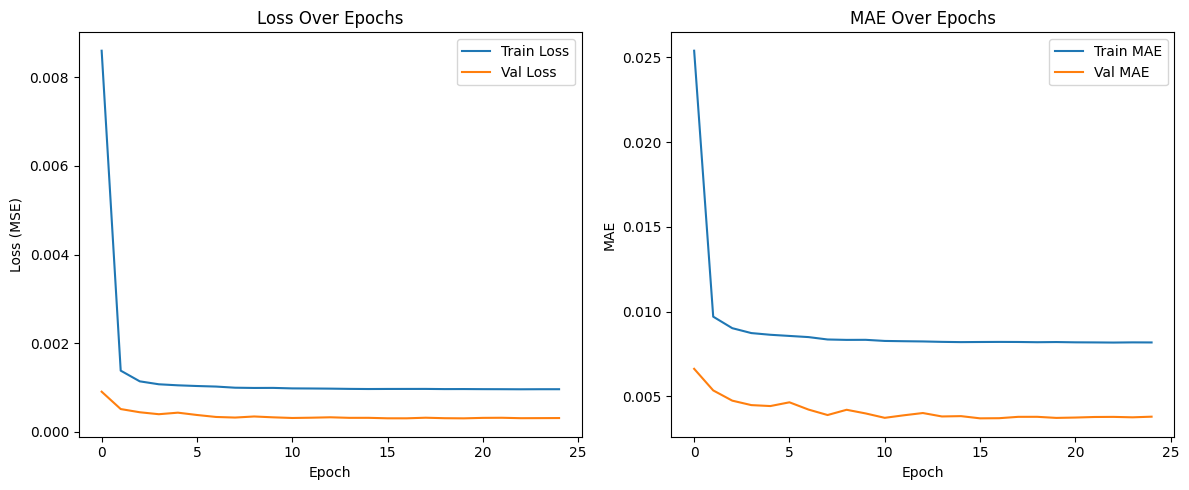

✅ Training plot saved as: ae_shallow_training.png


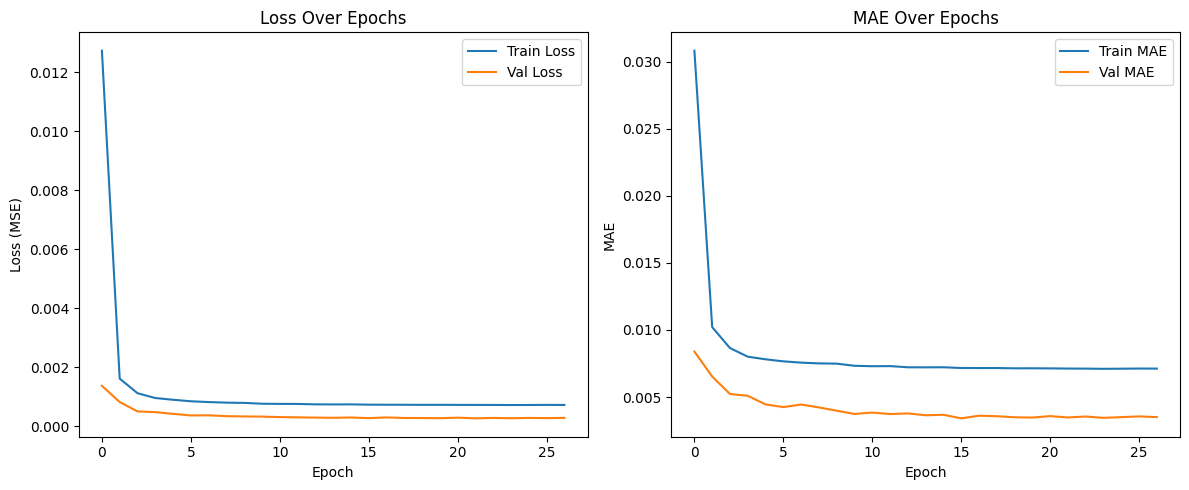

✅ Training plot saved as: ae_deep_training.png


In [10]:
# 6. Visualization: Loss Curve

plot_training_history(hist_shallow, save_path='ae_shallow_training.png')
plot_training_history(hist_deep, save_path='ae_deep_training.png')

4005/4005 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step

Shallow AE Evaluation
{'threshold': np.float64(0.0036321179882678406), 'precision': np.float64(0.5591296121097445), 'recall': np.float64(0.6207983193277311), 'f1': np.float64(0.5883524140865227), 'roc_auc': np.float64(0.9868382916844891), 'confusion_matrix': {'TP': np.int64(1773), 'FP': np.int64(1398), 'TN': np.int64(123904), 'FN': np.int64(1083)}}
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


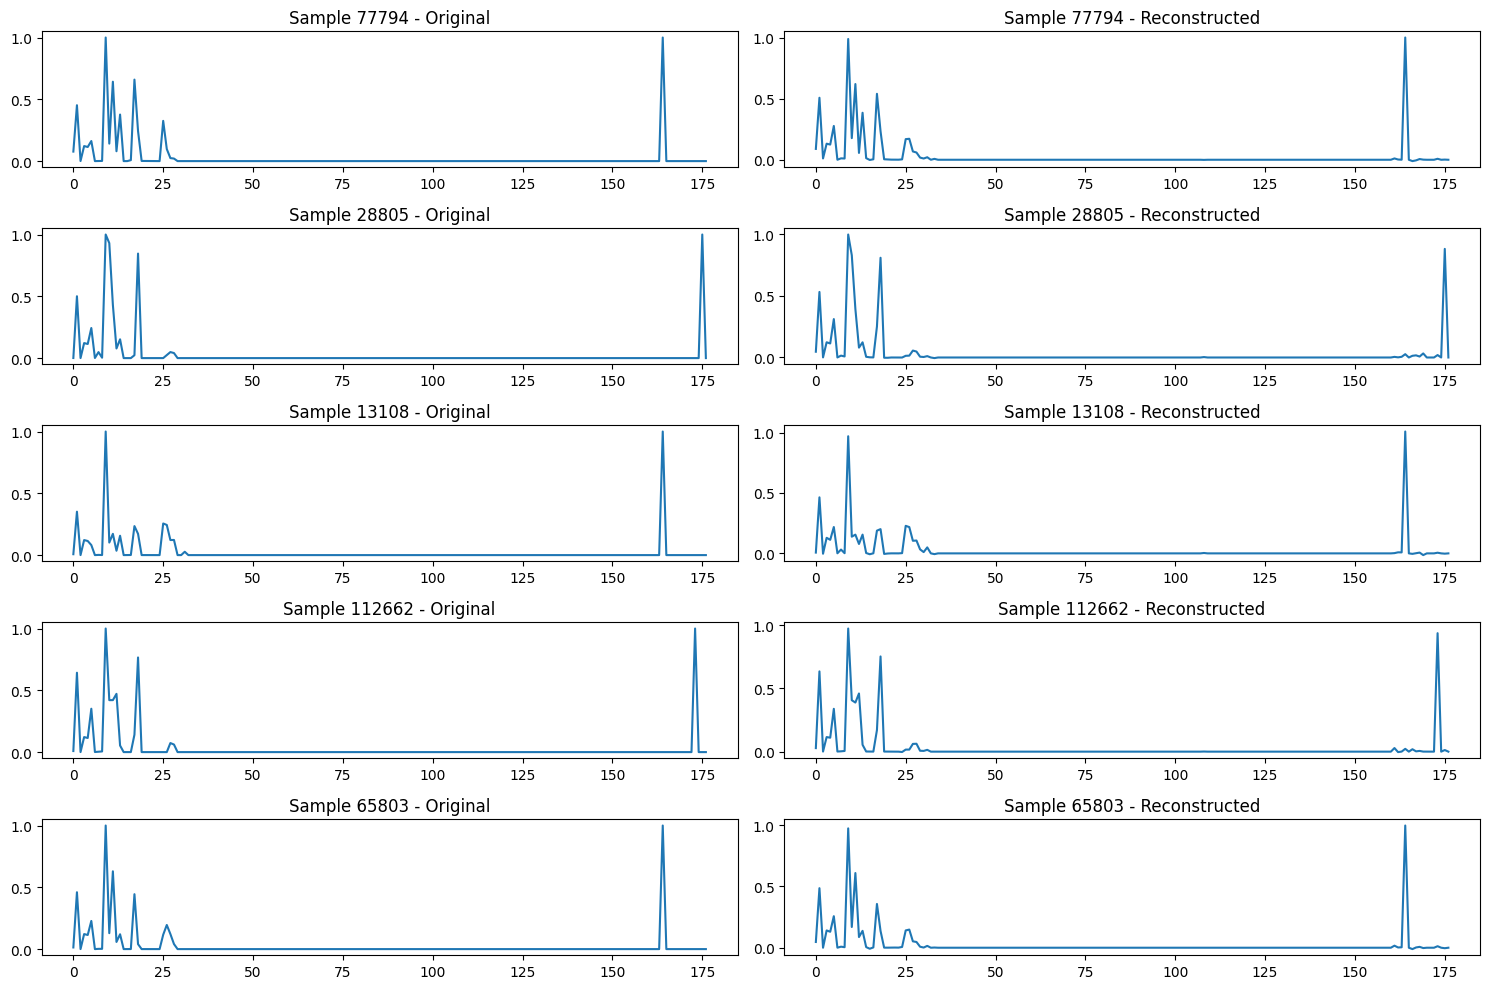


Deep AE Evaluation
{'threshold': np.float64(0.00389314565497648), 'precision': np.float64(0.6161573880284638), 'recall': np.float64(0.5154061624649859), 'f1': np.float64(0.5612964727816642), 'roc_auc': np.float64(0.9786009522003243), 'confusion_matrix': {'TP': np.int64(1472), 'FP': np.int64(917), 'TN': np.int64(124385), 'FN': np.int64(1384)}}
4005/4005 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


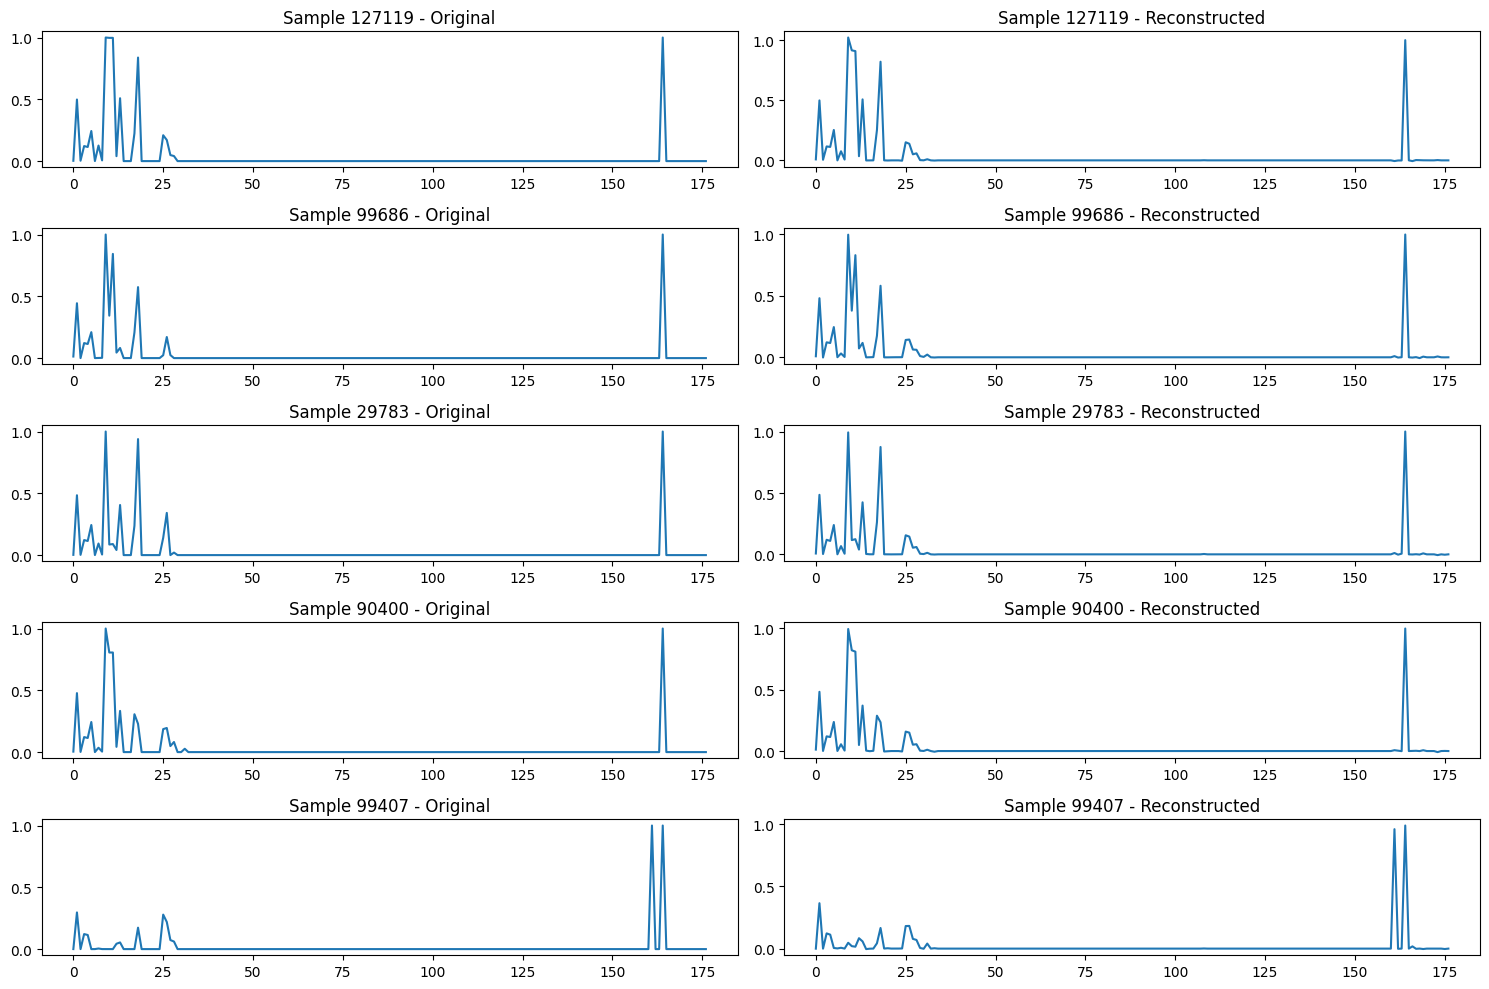

In [11]:
# 7. Evaluation
re_shallow = compute_reconstruction_error(model_shallow, X_test)
re_deep = compute_reconstruction_error(model_deep, X_test)

print("\nShallow AE Evaluation")
print(evaluate_anomaly_detection(re_shallow, y_test))
visualize_reconstruction(model_shallow, X_test.to_numpy())

print("\nDeep AE Evaluation")
print(evaluate_anomaly_detection(re_deep, y_test))
visualize_reconstruction(model_deep, X_test.to_numpy())

In [ ]:
# 8. Summary (markdown output manually written after run)